In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
pip install category_encoders

In [ ]:
pip install optuna

In [ ]:
#Formatting and loading the data
labels_headers=["TimingSlack_Optimized","Condition","Timing_Endpoint"]
features_headers=["TimingSlack_PreOpt"]
for i in range(31):
  features_headers.append("Feature_"+f"{i+1}")

features_headers.append("Condition")
features_headers.append("Timing_Endpoint")

In [ ]:
labels_df = pd.read_csv("/content/drive/MyDrive/DataScience_Final/mod_labels.csv", sep=r'\s+', header=None, names=labels_headers)
features_df = pd.read_csv("/content/drive/MyDrive/DataScience_Final/mod_features.csv", delim_whitespace=True, header=None,names=features_headers)

In [ ]:
merged_df = pd.merge(labels_df, features_df, on=["Condition", "Timing_Endpoint"])

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434218 entries, 0 to 434217
Data columns (total 35 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TimingSlack_Optimized  434218 non-null  float64
 1   Condition              434218 non-null  object 
 2   Timing_Endpoint        434218 non-null  object 
 3   TimingSlack_PreOpt     434218 non-null  float64
 4   Feature_1              434218 non-null  object 
 5   Feature_2              434218 non-null  float64
 6   Feature_3              434218 non-null  float64
 7   Feature_4              434218 non-null  float64
 8   Feature_5              434218 non-null  float64
 9   Feature_6              434218 non-null  float64
 10  Feature_7              434218 non-null  float64
 11  Feature_8              434218 non-null  int64  
 12  Feature_9              434218 non-null  float64
 13  Feature_10             434218 non-null  float64
 14  Feature_11             434218 non-nu

In [ ]:
# Drop 'Condition' and 'Timing_Endpoint' columns from merged_df
merged_df = merged_df.drop(['Condition', 'Timing_Endpoint'], axis=1)
merged_df['Feature_1'] = merged_df['Feature_1'].map({'na': 0, 'IO': 1})

In [ ]:
# Filter data based on specified slack range and conditions
filtered_df = merged_df[(merged_df['TimingSlack_Optimized'] >= -0.5) & (merged_df['TimingSlack_Optimized'] <= 0.3)]

In [ ]:
filter_header=filtered_df.columns.tolist()

In [ ]:
filtered_df.head()

,TimingSlack_Optimized,TimingSlack_PreOpt,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31
2,-0.34037,0.00392,0,5.96784,0.448554,0.684964,0.30,0.144,2.0,3,...,0.939682,12.39170,0.000914,0.006848,0.003915,0,62050900.0,0.2,0.684964,0.688879
3,-0.31559,0.03720,0,2.38351,0.452340,0.651678,0.17,0.000,3.0,4,...,0.940491,3.82652,0.000914,0.006848,0.037201,0,62050900.0,0.2,0.651678,0.688879
4,-0.30512,0.04230,0,2.51116,0.452798,0.646579,0.90,0.000,2.5,3,...,1.794660,3.22766,0.000914,0.006848,0.042300,0,62050900.0,0.2,0.646579,0.688879
5,-0.29530,0.04320,0,2.02236,0.453046,0.645679,0.20,0.000,2.5,3,...,1.794520,2.25021,0.000914,0.006848,0.043201,0,62050900.0,0.2,0.645679,0.688879
6,-0.28972,0.06090,0,2.02699,0.448554,0.627979,0.20,0.000,2.5,3,...,1.794560,2.25942,0.000914,0.006848,0.060901,0,62050900.0,0.2,0.627979,0.688879


In [ ]:
# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(filtered_df.drop(['TimingSlack_Optimized'], axis=1), filtered_df['TimingSlack_Optimized'], test_size=0.2)

def custom_asymmetric_loss_updated(y_true, y_pred):
    residual = y_true - y_pred
    loss = np.where(residual < 0, 50.0 * residual**2, residual**2)
    return np.mean(loss)

def objective_updated(trial):
    #Hyperparameter search space
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0)
    }

    #XGBoost regressor
    xgb_model = XGBRegressor(**xgb_params, objective='reg:squarederror', eval_metric='rmse', scale_pos_weight=1)

    # Train the model
    weights = [50.0 if y < 0 else 1.0 for y in y_train]
    xgb_model.fit(X_train, y_train, sample_weight=weights)

    # Predictions
    y_pred = xgb_model.predict(X_test)

    # Evaluate the model
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Penalty for positive slack values
    positive_slack_penalty = 0.5  # Adjust as needed
    y_pred_positive_penalty = [pred + positive_slack_penalty if pred >= 0 else pred for pred in y_pred]
    rmse_penalty = mean_squared_error(y_test, y_pred_positive_penalty, squared=False)

    # Combine both penalties (negative slack is already emphasized by the sample weights)
    combined_rmse = rmse + rmse_penalty

    return combined_rmse


[I 2023-12-13 03:16:57,971] A new study created in memory with name: no-name-b89df6f3-2560-4e41-9740-5531d3ee93f8
[I 2023-12-13 03:17:18,539] Trial 0 finished with value: 0.455625750144162 and parameters: {'learning_rate': 0.3131299740705414, 'n_estimators': 415, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.45799819979853634, 'colsample_bytree': 0.7798109580441974}. Best is trial 0 with value: 0.455625750144162.
[I 2023-12-13 03:17:29,735] Trial 1 finished with value: 0.4688484554366866 and parameters: {'learning_rate': 0.8794320291425152, 'n_estimators': 687, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.267999107549457, 'colsample_bytree': 0.8032652236927231}. Best is trial 0 with value: 0.455625750144162.
[I 2023-12-13 03:17:54,833] Trial 2 finished with value: 0.4586361274479726 and parameters: {'learning_rate': 0.367333583558484, 'n_estimators': 858, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.22517539482565768, 'colsample_bytree': 0.9641439483829939}. Best is tri

Tuned XGBoost Model (Optuna):
Best Hyperparameters: {'learning_rate': 0.2541838658695533, 'n_estimators': 356, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.4705729874838135, 'colsample_bytree': 0.8184305694553793}
RMSE: 0.04411694165815421
RMSE for negative slack 0ns to -0.5ns: 0.022818824180143128


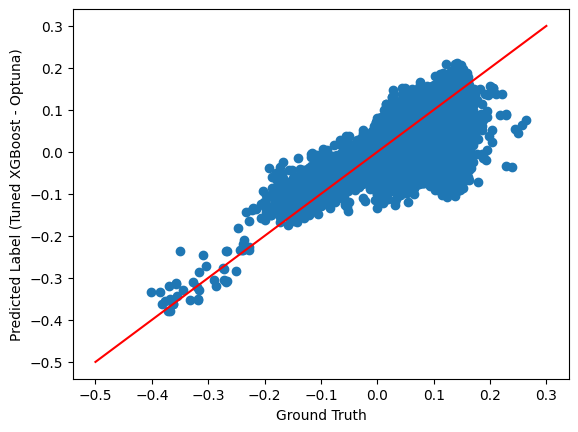

In [ ]:
import optuna
# Run Optuna optimization
optuna_study = optuna.create_study(direction='minimize')
optuna_study.optimize(objective_updated, n_trials=20, n_jobs=-1)

# Get the best hyperparameters
best_xgb_params_optuna = optuna_study.best_params

# Train the model with the best hyperparameters
best_xgb_model_optuna_tuned = XGBRegressor(**best_xgb_params_optuna, objective='reg:squarederror', eval_metric='rmse', scale_pos_weight=1)
best_xgb_model_optuna_tuned.fit(X_train, y_train, sample_weight=[50.0 if y < 0 else 1.0 for y in y_train])

# Predictions
y_pred_optuna_tuned = best_xgb_model_optuna_tuned.predict(X_test)

# Evaluate the model
rmse_optuna_tuned = mean_squared_error(y_test, y_pred_optuna_tuned, squared=False)
r2_optuna_tuned = r2_score(y_test, y_pred_optuna_tuned)
print('Tuned XGBoost Model (Optuna):')
print('Best Hyperparameters:', best_xgb_params_optuna)
print('RMSE:', rmse_optuna_tuned)

# Calculate the RMSE for negative slack 0ns to -0.5ns
negative_slack_optuna = (y_test <= 0) & (y_test >= -0.5)
y_test_neg_optuna = y_test[negative_slack_optuna]
y_pred_neg_optuna_tuned = y_pred_optuna_tuned[negative_slack_optuna]
rmse_neg_optuna_tuned = mean_squared_error(y_test_neg_optuna, y_pred_neg_optuna_tuned, squared=False)
print('RMSE for negative slack 0ns to -0.5ns:', rmse_neg_optuna_tuned)

# Correlation plot
plt.scatter(y_test, y_pred_optuna_tuned)
plt.plot([-0.5, 0.3], [-0.5, 0.3], color='red')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Label (Tuned XGBoost - Optuna)')
plt.show()


[I 2023-12-13 04:13:06,627] A new study created in memory with name: no-name-79705129-8739-4abf-88a0-5c8bc0e73535
[I 2023-12-13 04:13:29,232] Trial 0 finished with value: 0.024236710118972504 and parameters: {'learning_rate': 0.13561486178557644, 'num_leaves': 159, 'n_estimators': 93, 'max_depth': 11, 'min_child_weight': 8.6481433028979, 'reg_lambda': 6.0157111457585515, 'reg_alpha': 0.35359637613431305}. Best is trial 0 with value: 0.024236710118972504.
[I 2023-12-13 04:13:48,753] Trial 1 finished with value: 0.029916932518241953 and parameters: {'learning_rate': 0.8161521733351181, 'num_leaves': 80, 'n_estimators': 339, 'max_depth': 5, 'min_child_weight': 9.815512064051877, 'reg_lambda': 7.0271482307792015, 'reg_alpha': 6.026142093750908}. Best is trial 0 with value: 0.024236710118972504.
[I 2023-12-13 04:14:43,869] Trial 3 finished with value: 0.031161568361513056 and parameters: {'learning_rate': 0.8109424250187527, 'num_leaves': 196, 'n_estimators': 431, 'max_depth': 6, 'min_child

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 346852, number of used features: 29
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Tuned Lig

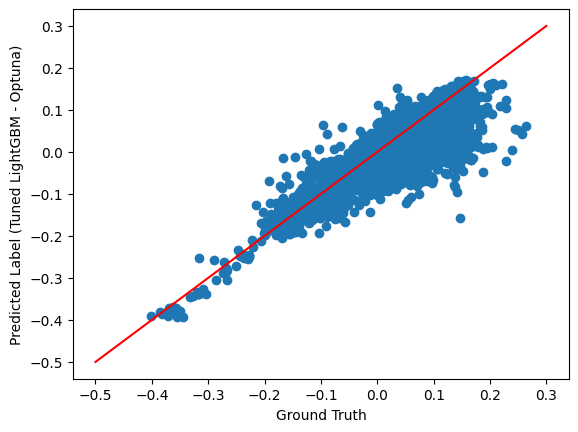

In [ ]:
# Define a custom asymmetric objective function
def custom_asymmetric_loss_objective(y_true, y_pred):
    residual = y_true - y_pred
    grad = np.where(residual < 0, -50.0 * residual, -residual)
    hess = np.where(residual < 0, 50.0, 1.0)
    return grad, hess

# Define the objective function for Optuna optimization
def objective_lightgbm(trial):
    params_lightgbm = {
        'objective': custom_asymmetric_loss_objective,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10)
    }

    model_lgbm = LGBMRegressor(**params_lightgbm)
    model_lgbm.fit(X_train, y_train)
    y_pred_lgbm = model_lgbm.predict(X_test)

    rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm, squared=False)
    return rmse_lgbm

# Run Optuna optimization for LightGBM
study_lightgbm = optuna.create_study(direction='minimize')
study_lightgbm.optimize(objective_lightgbm, n_trials=20, n_jobs=-1)

# Get the best hyperparameters for LightGBM
best_params_lightgbm = study_lightgbm.best_params

# Train the LightGBM model with the best hyperparameters
best_model_lgbm = LGBMRegressor(**best_params_lightgbm, objective=custom_asymmetric_loss_objective)
best_model_lgbm.fit(X_train, y_train)
y_pred_lgbm_tuned = best_model_lgbm.predict(X_test)

# Evaluate the LightGBM model
rmse_lgbm_tuned = mean_squared_error(y_test, y_pred_lgbm_tuned, squared=False)
r2_lgbm_tuned = r2_score(y_test, y_pred_lgbm_tuned)

# Calculate the RMSE for negative slack 0ns to -0.5ns
y_test_neg_lgbm = y_test[negative_slack_optuna]
y_pred_neg_lgbm_tuned = y_pred_lgbm_tuned[negative_slack_optuna]
rmse_neg_lgbm_tuned = mean_squared_error(y_test_neg_lgbm, y_pred_neg_lgbm_tuned, squared=False)

# Display results for LightGBM
print('Tuned LightGBM Model (Optuna):')
print('Best Hyperparameters:', best_params_lightgbm)
print('RMSE:', rmse_lgbm_tuned)
print('R2:', r2_lgbm_tuned)
print('RMSE for negative slack 0ns to -0.5ns:', rmse_neg_lgbm_tuned)

# Correlation plot for LightGBM
plt.scatter(y_test, y_pred_lgbm_tuned)
plt.plot([-0.5, 0.3], [-0.5, 0.3], color='red')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Label (Tuned LightGBM - Optuna)')
plt.show()

Epoch 1/7, Loss: 1063.2705078125
Epoch 2/7, Loss: 62539.40234375
Epoch 3/7, Loss: 0.016851186752319336
Epoch 4/7, Loss: 0.012405699118971825
Epoch 5/7, Loss: 0.012255732901394367
Epoch 6/7, Loss: 0.029154833406209946
Epoch 7/7, Loss: 0.02012636512517929
Custom RMSE: 0.0945105031132698
Filtered RMSE (for values between -0.5 and 0): 0.04637943580746651


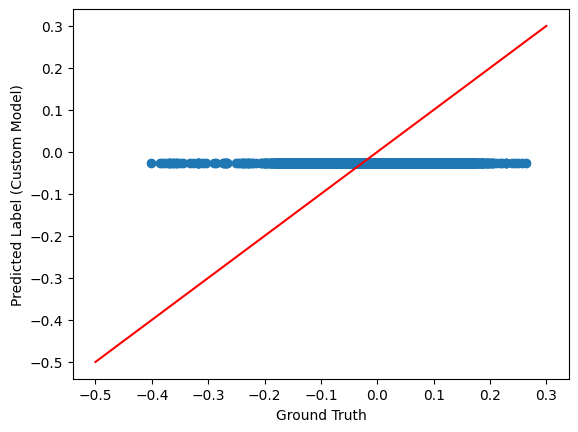

In [ ]:
# Define a custom neural network model
class CustomNN(nn.Module):
    def __init__(self, input_size):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create PyTorch tensors for the dataset
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create a custom dataset and data loader
custom_dataset = TensorDataset(X_train_tensor, y_train_tensor)
custom_data_loader = DataLoader(custom_dataset, batch_size=64, shuffle=True)

# Custom loss function with different weight for negative slack values
class CustomMSELoss(nn.Module):
    def __init__(self, negative_weight):
        super(CustomMSELoss, self).__init__()
        self.negative_weight = negative_weight

    def forward(self, predictions, targets):
        difference = predictions - targets
        weights = torch.ones_like(targets)
        weights[targets < 0] = self.negative_weight
        weighted_sq_diff = weights * (difference ** 2)
        loss = weighted_sq_diff.mean()
        return loss

# Create the custom neural network model
custom_model = CustomNN(input_size=X_train.shape[1])
custom_optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001)
num_epochs = 7
custom_losses = []

negative_weight_custom = 50
custom_criterion = CustomMSELoss(negative_weight=negative_weight_custom)

# Training Loop for the custom model
for epoch in range(num_epochs):
    epoch_losses_custom = []
    for inputs, labels in custom_data_loader:
        custom_optimizer.zero_grad()
        custom_outputs = custom_model(inputs)
        custom_loss = custom_criterion(custom_outputs, labels.unsqueeze(1))
        custom_loss.backward()
        custom_optimizer.step()
        epoch_losses_custom.append(custom_loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {custom_loss.item()}")
    epoch_loss_custom = np.mean(epoch_losses_custom)
    custom_losses.append(epoch_loss_custom)

# Evaluate the custom model
custom_model.eval()
with torch.no_grad():
    custom_predictions = custom_model(X_test_tensor).squeeze()
    custom_predictions = custom_predictions.numpy()
    y_test_custom_np = y_test_tensor.numpy()

custom_rmse = np.sqrt(mean_squared_error(y_test_custom_np, custom_predictions))
print(f"Custom RMSE: {custom_rmse}")

mask_custom = (y_test_custom_np >= -0.5) & (y_test_custom_np <= 0)
filtered_y_test_custom = y_test_custom_np[mask_custom]
filtered_predictions_custom = custom_predictions[mask_custom]

# Calculate RMSE for the filtered data
filtered_rmse_custom = np.sqrt(mean_squared_error(filtered_y_test_custom, filtered_predictions_custom))
print(f"Filtered RMSE (for values between -0.5 and 0): {filtered_rmse_custom}")

# Correlation plot for the custom model
plt.scatter(y_test_custom_np, custom_predictions)
plt.plot([-0.5, 0.3], [-0.5, 0.3], color='red')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Label (Custom Model)')
plt.show()


In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


0:	learn: 0.0612318	total: 380ms	remaining: 6m 19s
1:	learn: 0.0608846	total: 648ms	remaining: 5m 23s
2:	learn: 0.0605532	total: 935ms	remaining: 5m 10s
3:	learn: 0.0602091	total: 1.21s	remaining: 5m 2s
4:	learn: 0.0598692	total: 1.49s	remaining: 4m 56s
5:	learn: 0.0595328	total: 1.75s	remaining: 4m 50s
6:	learn: 0.0592071	total: 2.03s	remaining: 4m 48s
7:	learn: 0.0588642	total: 2.31s	remaining: 4m 46s
8:	learn: 0.0585336	total: 2.77s	remaining: 5m 4s
9:	learn: 0.0582058	total: 3.27s	remaining: 5m 23s
10:	learn: 0.0578957	total: 3.77s	remaining: 5m 39s
11:	learn: 0.0575812	total: 4.28s	remaining: 5m 52s
12:	learn: 0.0572857	total: 4.75s	remaining: 6m
13:	learn: 0.0569700	total: 5.22s	remaining: 6m 7s
14:	learn: 0.0566794	total: 5.67s	remaining: 6m 12s
15:	learn: 0.0563798	total: 6.17s	remaining: 6m 19s
16:	learn: 0.0560931	total: 6.67s	remaining: 6m 25s
17:	learn: 0.0557876	total: 7.13s	remaining: 6m 28s
18:	learn: 0.0555020	total: 7.58s	remaining: 6m 31s
19:	learn: 0.0552062	total: 8

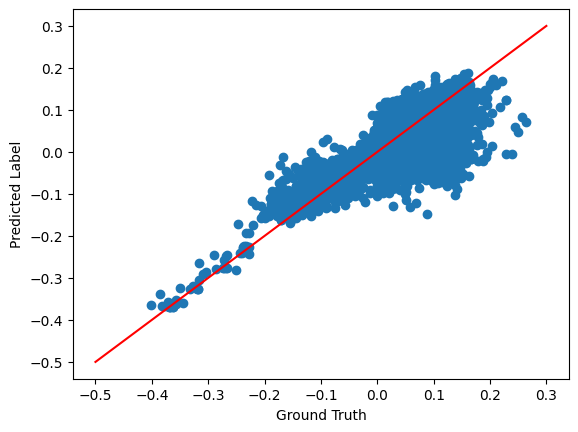

In [ ]:
#Extra Credit
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=10,
    l2_leaf_reg=1,
    loss_function='RMSE',
    eval_metric='RMSE',
    cat_features=['Feature_1']
)


weights = [50.0 if y < 0 else 1.0 for y in y_train]

cat_model.fit(X_train, y_train, sample_weight=weights)


y_pred_cat = cat_model.predict(X_test)


rmse_cat = mean_squared_error(y_test, y_pred_cat, squared=False)
r2_cat = r2_score(y_test, y_pred_cat)
print('RMSE:', rmse_cat)
print('R2:', r2_cat)


negative_slack = (y_test <= 0) & (y_test >= -0.5)
y_test_neg = y_test[negative_slack]
y_pred_neg_cat = y_pred_cat[negative_slack]
rmse_neg_cat = mean_squared_error(y_test_neg, y_pred_neg_cat, squared=False)
print('RMSE for negative slack 0ns to -0.5ns:', rmse_neg_cat)


plt.scatter(y_test, y_pred_cat)
plt.plot([-0.5, 0.3], [-0.5, 0.3], color='red')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Label')
plt.show()